# Packages and Libraries

In [89]:
import os
import json
import math
# from google.colab import drive
import wave
import pathlib

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


import tensorflow as tf 
from tensorflow.keras import layers, models
import tensorflow.keras as keras

import librosa
import IPython.display as display
import soundfile as sf

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder


In [21]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Pieline

## Load the data
Load the raw audio data from files (e.g., WAV, MP3) into a format that can be processed. Libraries like librosa or soundfile are commonly used for this purpose.

## Resample the data
If the audio data has a different sampling rate than what your model expects, you may need to resample it to the desired rate.

## Normalization
Normalize the audio signal to ensure that the amplitudes are within a specific range (often between -1 and 1). This helps with numerical stability during training.

## Trimming and Padding
Trim or pad the audio data to a consistent length. Some machine learning models may require fixed-length inputs. Padding is typically done with silence or zeros.

## Spectral Representations
Convert the audio signal into a frequency domain representation, such as a spectrogram or mel spectrogram. This involves applying a Short-Time Fourier Transform (STFT) or Mel-Frequency Cepstral Coefficients (MFCC) to extract relevant features.

## Augmentation
Apply data augmentation techniques to increase the diversity of the training set. This can include random pitch shifting, time stretching, or adding background noise.

## Feature Scaling
Scale the features to have zero mean and unit variance. This step helps the model converge faster during training.

## Labeling
If your task involves supervised learning, make sure to associate each audio clip with its corresponding label or category.

## Data Splitting
Split the dataset into training, validation, and testing sets. This helps in assessing the model's performance on unseen data.

## Conversion to TensorFlow 
Convert the preprocessed data into a format suitable for the deep learning framework you're using. This often involves creating custom datasets or using the available data loading utilities provided by the framework.

## Model Training
Train your machine learning model using the preprocessed data.

## Model Evaluation
Evaluate the trained model on the validation and test sets to assess its performance.

## Inference
Use the trained model to make predictions on new, unseen audio data

# Loading Raw Audio Data


## Mount google drive
adisamproject@gmail.com

In [3]:
# drive.mount('/content/drive')

In [4]:
# DATASET_PATH = "/content/drive/My Drive/2_Luganda/dataset"
# data_dir = pathlib.Path(DATASET_PATH)

In [22]:
DATASET_PATH = 'own/'
data_dir = pathlib.Path(DATASET_PATH)
PROCESSED_DATA_PATH = 'processedData/'

## Commands in the dataset
The dataset's audio clips are of 5 classes and a wakeword stored in six folders corresponding to each speech command:
- `gaali` (Wakeword)
- `ddyo`
- `kkono`
- `mu maaso`
- `emabega`
- `yimirira`


In [23]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
print('Commands:', commands)

Commands: ['emabega' 'ddyo' 'gaali' 'kkono' 'mu masso' 'yimirira']


## Number of audio files per command

In [26]:
def count_audio_files_in_subfolders(data_dir):
    counts = {}

    # Iterate through subfolders
    for subfolder in os.listdir(data_dir):
        subfolder_path = os.path.join(data_dir, subfolder)

        # Check if it's a directory
        if os.path.isdir(subfolder_path):
            # Count the number of audio files in the subfolder
            audio_files_count = len([f for f in os.listdir(subfolder_path) if f.endswith('.wav')])
            counts[subfolder] = audio_files_count

    return counts

# Get the counts
counts = count_audio_files_in_subfolders(data_dir)

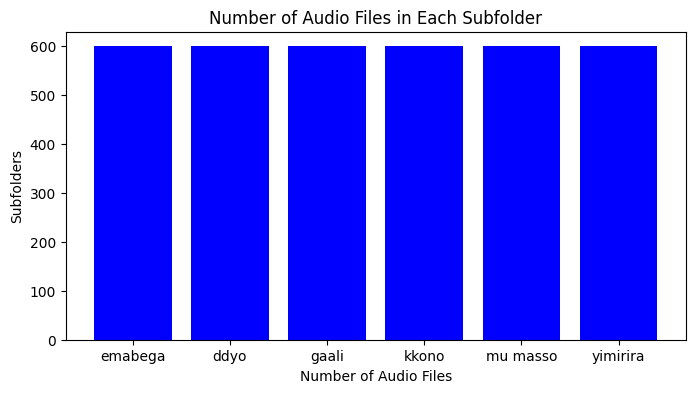

In [27]:
plt.figure(figsize=(8, 4))
plt.bar(list(counts.keys()), list(counts.values()), color='blue')
plt.xlabel('Number of Audio Files')
plt.ylabel('Subfolders')
plt.title('Number of Audio Files in Each Subfolder')
plt.show()

# Inspect the audio data

## Insect one audio file

In [28]:
example_audio_path = 'own/ddyo/audio #2001.wav'
audio_signal, sample_rate = librosa.load(example_audio_path)
audio = wave.open(example_audio_path, 'rb')

### Audio Parameters

In [29]:
number_of_channel = audio.getnchannels()
sample_width = audio.getsampwidth()
frame_rate = audio.getframerate()
number_of_frames = audio.getnframes()

In [30]:
print('Number of channels:', number_of_channel)
print('Sample width:',       sample_width)
print('frame rate:',         frame_rate)
print('Number of frames:',   number_of_frames)
print('Parameters:',         audio.getparams())

Number of channels: 1
Sample width: 2
frame rate: 16000
Number of frames: 15360
Parameters: _wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=15360, comptype='NONE', compname='not compressed')


In [31]:
duration = librosa.get_duration(y=audio_signal, sr=sample_rate)
print(f"Duration: {duration} seconds")
print(f"Sample Rate: {sample_rate} Hz")

Duration: 0.96 seconds
Sample Rate: 22050 Hz


### Visualize the audio waveform

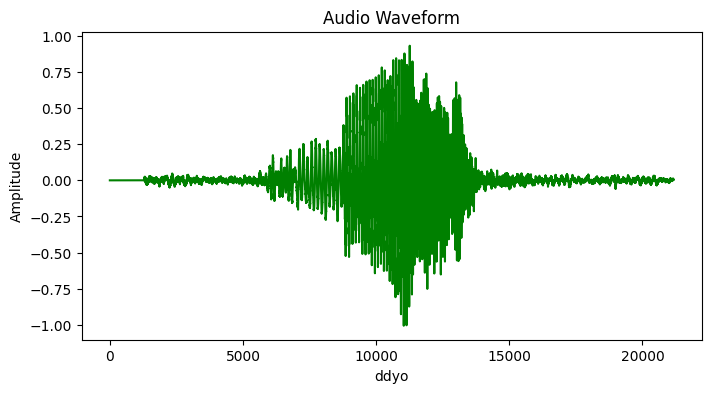

In [32]:
plt.figure(figsize=(8, 4))
plt.plot(audio_signal, color='green')
plt.title('Audio Waveform')
plt.xlabel('ddyo')
plt.ylabel('Amplitude')
plt.show()

### Amplitude Distribution

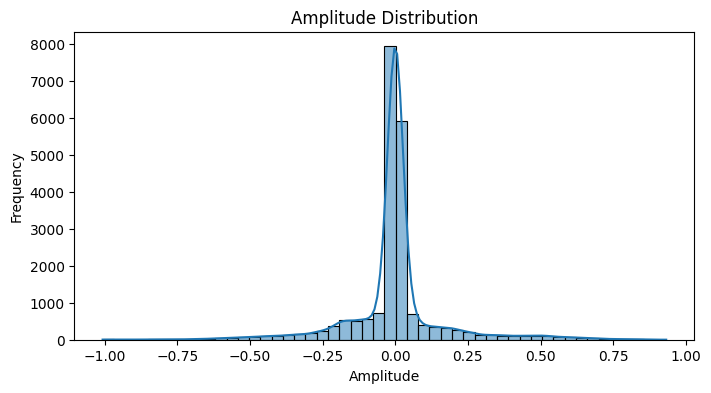

In [33]:
plt.figure(figsize=(8, 4))
sns.histplot(audio_signal, bins=50, kde=True)
plt.title('Amplitude Distribution')
plt.xlabel('Amplitude')
plt.ylabel('Frequency')
plt.show()

# Preprocess the audio data

In [34]:
def process_audio(audio_path, desired_duration=2, noise_level=0.002):
    # Load audio file
    audio_signal, sample_rate = librosa.load(audio_path, sr=None, mono=True)

    # Trim audio to desired duration if needed
    desired_samples = int(desired_duration * sample_rate)
    if len(audio_signal) > desired_samples:
        trimmed_signal, _ = librosa.effects.trim(audio_signal, frame_length=2048)

        # Fix length of the trimmed signal
        if len(trimmed_signal) < desired_samples:
            pad_amount = desired_samples - len(trimmed_signal)
            trimmed_signal = np.pad(trimmed_signal, (0, pad_amount))
        else:
            trimmed_signal = trimmed_signal[:desired_samples]
    else:
        trimmed_signal = audio_signal

    return trimmed_signal, sample_rate

In [35]:
def preprocess_audio_in_subfolders(root_folder, output_folder, desired_duration=2):
    # Iterate through subfolders
    for subfolder in os.listdir(root_folder):
        subfolder_path = os.path.join(root_folder, subfolder)

        # Check if it's a directory
        if os.path.isdir(subfolder_path):
            # Create output subfolder if it doesn't exist
            output_subfolder = os.path.join(output_folder, subfolder)
            os.makedirs(output_subfolder, exist_ok=True)

            # Iterate through audio files in the subfolder
            for audio_file in os.listdir(subfolder_path):
                audio_path = os.path.join(subfolder_path, audio_file)

                # Process each audio file (trim only)
                trimmed_audio, sample_rate = process_audio(audio_path, desired_duration)

                # Save the preprocessed audio file in the output subfolder using soundfile
                output_audio_path = os.path.join(output_subfolder, audio_file)
                sf.write(output_audio_path, trimmed_audio, sample_rate)


In [36]:
root_folder = DATASET_PATH
output_folder = PROCESSED_DATA_PATH
preprocess_audio_in_subfolders(root_folder, output_folder)

## Set new paths for the processed data

In [48]:
DATASET_PATH = 'processedData/'
data_dir = pathlib.Path(DATASET_PATH)
JSON_PATH = "data.json"

# Feature extraction

In [53]:
def extract_features(root_folder, desired_duration=2, n_mfcc=13, hop_length=512, n_fft=2048):
    features = []
    labels = []

    for foldername in os.listdir(root_folder):
        folder_path = os.path.join(root_folder, foldername)

        if os.path.isdir(folder_path):
            for audio_filename in os.listdir(folder_path):
                audio_path = os.path.join(folder_path, audio_filename)

                # Load audio file and extract features
                try:
                    audio_signal, sample_rate = librosa.load(audio_path, duration=desired_duration)
                    mfccs = librosa.feature.mfcc(y=audio_signal, sr=sample_rate, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=n_fft)
                    mfccs_mean = np.mean(mfccs, axis=1)  # Take the mean of MFCCs over time
                    features.append(mfccs_mean)
                    labels.append(foldername)  # Assuming folder names are the labels/categories
                except Exception as e:
                    print(f"Error encountered while processing {audio_path}: {e}")

    return np.array(features), np.array(labels)

In [54]:
root_folder = DATASET_PATH
features, labels = extract_features(root_folder)
print("Features shape:", features.shape)
print("Labels:", labels)


Features shape: (3600, 13)
Labels: ['emabega' 'emabega' 'emabega' ... 'yimirira' 'yimirira' 'yimirira']


## Data augmentation

In [62]:
# Define data augmentation function
def apply_augmentation(audio_signal, sample_rate, desired_duration=2, pitch_shift_range=2, time_stretch_range=0.2, noise_level=0.002):
    # Random pitch shifting
    pitch_shift_steps = np.random.uniform(-pitch_shift_range, pitch_shift_range)
    augmented_audio = librosa.effects.pitch_shift(audio_signal, sr=sample_rate, n_steps=pitch_shift_steps)

    # Random time stretching
    time_stretch_factor = np.random.uniform(1 - time_stretch_range, 1 + time_stretch_range)
    augmented_audio = librosa.effects.time_stretch(augmented_audio, rate=time_stretch_factor)

    # Add random noise
    noise = np.random.normal(scale=noise_level, size=len(augmented_audio))
    augmented_audio += noise

    # Trim audio to desired duration if needed
    desired_samples = int(desired_duration * sample_rate)
    if len(augmented_audio) > desired_samples:
        augmented_audio = augmented_audio[:desired_samples]
    else:
        pad_amount = desired_samples - len(augmented_audio)
        augmented_audio = np.pad(augmented_audio, (0, pad_amount))

    return augmented_audio

def augment_data(audio_signal, sample_rate, label, desired_duration=2, pitch_shift_range=2, time_stretch_range=0.2, noise_level=0.002, n_mfcc=13, hop_length=512, n_fft=2048):
    augmented_features = []
    augmented_labels = []

    # Apply data augmentation to the audio signal
    augmented_audio = apply_augmentation(audio_signal, sample_rate, desired_duration, pitch_shift_range, time_stretch_range, noise_level)
    
    # Extract features from the augmented audio signal
    try:
        mfccs = librosa.feature.mfcc(y=augmented_audio, sr=sample_rate, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=n_fft)
        mfccs_mean = np.mean(mfccs, axis=1)  # Take the mean of MFCCs over time
        augmented_features.append(mfccs_mean)
        augmented_labels.append(label)
    except Exception as e:
        print(f"Error encountered while processing augmented audio: {e}")

    return np.array(augmented_features), np.array(augmented_labels)



## Labelling

In [91]:
def label_audio_files(root_folder):
    labels = []
    file_paths = []

    for foldername in os.listdir(root_folder):
        folder_path = os.path.join(root_folder, foldername)

        if os.path.isdir(folder_path):
            for audio_filename in os.listdir(folder_path):
                audio_path = os.path.join(folder_path, audio_filename)

                # Add label and file path to lists
                labels.append(foldername)
                file_paths.append(audio_path)

    return labels, file_paths

In [92]:
labels, file_paths = label_audio_files(DATASET_PATH)

In [93]:
# Instantiate LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform labels
encoded_labels = label_encoder.fit_transform(labels)

# Define the number of classes
num_classes = len(label_encoder.classes_)


## Spilt the data

In [94]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [95]:
print(X_train.shape)
print(X_test.shape)

(2880, 13)
(720, 13)


## Convert to tf

In [96]:
def create_dataset(features, labels, batch_size=32, shuffle_buffer_size=1000):
    # Convert features and labels to TensorFlow tensors
    features = tf.constant(features)
    labels = tf.constant(labels)
    
    # Create dataset from tensors
    dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    
    # Shuffle and batch the dataset
    dataset = dataset.shuffle(buffer_size=shuffle_buffer_size).batch(batch_size)
    
    return dataset

train_dataset = create_dataset(X_train, y_train)
test_dataset = create_dataset(X_test, y_test)



## Model 1

In [99]:
num_epochs = 10  # Adjust as needed

# Define the number of features and classes
num_features = features.shape[1]  # Assuming features.shape[1] gives the number of features
num_classes = len(np.unique(labels))

# Define input shape based on your data
input_shape = (num_features,)

# Define model architecture
model = tf.keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=input_shape),
    layers.Dense(32, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['Accuracy'])

In [100]:
# Train the model
history = model.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset)

# Evaluate the model
loss, accuracy = model.evaluate(test_dataset)

print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

Epoch 1/10


2024-02-08 14:11:33.216952: W tensorflow/core/framework/op_kernel.cc:1816] OP_REQUIRES failed at cast_op.cc:122 : UNIMPLEMENTED: Cast string to float is not supported


UnimplementedError: Graph execution error:

Detected at node Cast_1 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/traitlets/config/application.py", line 1077, in launch_instance

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 529, in dispatch_queue

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 518, in process_one

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 424, in dispatch_shell

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 766, in execute_request

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipykernel_13329/3476920975.py", line 2, in <module>

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1155, in train_step

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1249, in compute_metrics

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/keras/src/engine/compile_utils.py", line 620, in update_state

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/keras/src/utils/metrics_utils.py", line 77, in decorated

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/keras/src/metrics/base_metric.py", line 140, in update_state_fn

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/keras/src/metrics/base_metric.py", line 708, in update_state

Cast string to float is not supported
	 [[{{node Cast_1}}]] [Op:__inference_train_function_4864]

# Split into Train and validation

In [44]:
def create_tf_dataset(root_folder, batch_size=64, validation_split=0.2):
    processed_audios = []

    # Iterate through subfolders
    for subfolder in os.listdir(root_folder):
        subfolder_path = os.path.join(root_folder, subfolder)

        # Check if it's a directory
        if os.path.isdir(subfolder_path):
            # Iterate through audio files in the subfolder
            for audio_file in os.listdir(subfolder_path):
                audio_path = os.path.join(subfolder_path, audio_file)

                # Process each audio file
                processed_audio, label = process_audio(audio_path)
                processed_audios.append((processed_audio, label))

    # Shuffle the data
    np.random.shuffle(processed_audios)

    # Split into training and validation sets
    split_index = int(len(processed_audios) * (1 - validation_split))
    train_data = processed_audios[:split_index]
    val_data = processed_audios[split_index:]

    # Create TensorFlow datasets
    train_ds = tf.data.Dataset.from_generator(lambda: train_data, output_signature=(
        tf.TensorSpec(shape=(None,), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    ))
    val_ds = tf.data.Dataset.from_generator(lambda: val_data, output_signature=(
        tf.TensorSpec(shape=(None,), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    ))

    # Batch the datasets
    train_ds = train_ds.batch(batch_size)
    val_ds = val_ds.batch(batch_size)

    return train_ds, val_ds



In [45]:
root_folder = PROCESSED_DATA_PATH
train_ds, val_ds = create_tf_dataset(root_folder, batch_size=64, validation_split=0.2)

## spectrograms

In [46]:
def extract_spectrograms(root_folder, desired_duration=2, noise_level=0.002):
    spectrograms = []
    sample_rates = []

    for foldername in os.listdir(root_folder):
        folder_path = os.path.join(root_folder, foldername)

        if os.path.isdir(folder_path):
            for audio_filename in os.listdir(folder_path):
                audio_path = os.path.join(folder_path, audio_filename)

                # Process audio (trimming and noise removal)
                processed_audio, sample_rate = process_audio(audio_path, desired_duration, noise_level)

                # Extract Mel spectrogram features
                mel_spectrogram = librosa.feature.melspectrogram(y=processed_audio, sr=sample_rate)
                log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

                spectrograms.append(log_mel_spectrogram)
                sample_rates.append(sample_rate)

    return spectrograms, sample_rates


In [47]:
spectrograms, sample_rates = extract_spectrograms(PROCESSED_DATA_PATH)

## Augementation

In [59]:
import numpy as np

def apply_augmentation(spectrograms, sample_rates, pitch_shift_range=2, time_stretch_range=0.2, noise_level=0.002):
    augmented_spectrograms = []
    for spectrogram, sample_rate in zip(spectrograms, sample_rates):
        # Convert spectrogram back to audio signal
        y = librosa.feature.inverse.mel_to_audio(np.asarray(spectrogram), sr=sample_rate)

        # Random pitch shifting
        pitch_shift_steps = np.random.uniform(-pitch_shift_range, pitch_shift_range)
        spectrogram_shifted = librosa.effects.pitch_shift(y, sr=sample_rate, n_steps=pitch_shift_steps)

        # Random time stretching
        time_stretch_factor = np.random.uniform(1 - time_stretch_range, 1 + time_stretch_range)
        spectrogram_stretched = librosa.effects.time_stretch(spectrogram_shifted, rate=time_stretch_factor)

        # Add random noise
        noise = np.random.normal(scale=noise_level, size=len(spectrogram_stretched))
        spectrogram_noisy = spectrogram_stretched + noise

        augmented_spectrograms.append(spectrogram_noisy)

    return augmented_spectrograms


## Feature scaling

In [58]:
# # After extracting spectrograms and applying data augmentation
# augmented_spectrograms = apply_augmentation(spectrograms, sample_rate)

# # After applying data augmentation, scale the features
# scaled_spectrograms, scaler = scale_features(augmented_spectrograms)

# Save the scaler object for later use
# # You can use joblib to save and load the scaler
# from joblib import dump
# dump(scaler, 'scaler.joblib')


TypeError: 'int' object is not iterable

In [100]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.3,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 3600 files belonging to 6 classes.
Using 2520 files for training.
Using 1080 files for validation.

label names: ['ddyo' 'emabega' 'gaali' 'kkono' 'mu masso' 'yimirira']


### The audio clips have a shape of `(batch, samples, channels)`.

In [101]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [102]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [103]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [104]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


### Plot a few audio waveforms:

In [105]:
label_names[[1,2,3,0,4,5]]

array(['emabega', 'gaali', 'kkono', 'ddyo', 'mu masso', 'yimirira'],
      dtype='<U8')

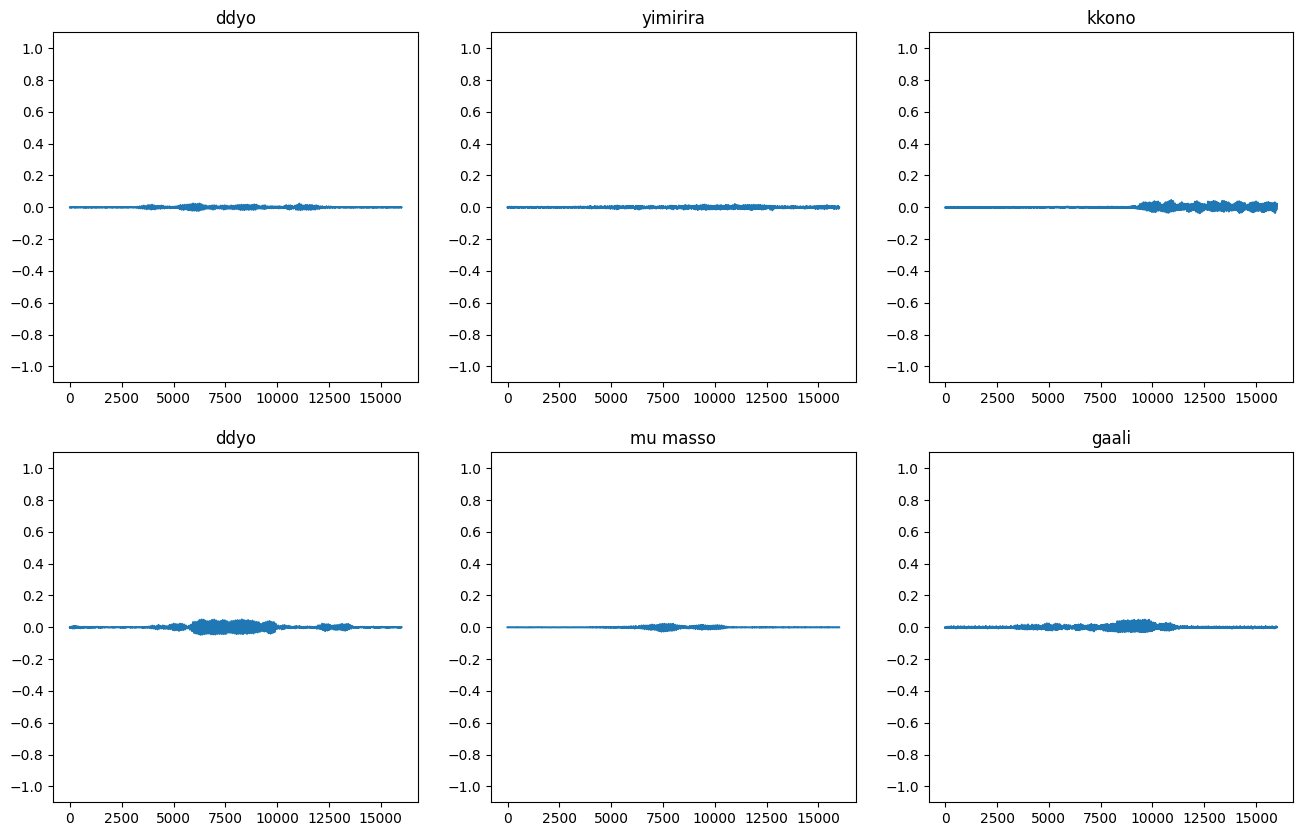

In [106]:
plt.figure(figsize=(16, 10))
rows = 2
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

In [107]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

### The shapes of a tensorized waveform and the corresponding spectrogram, and play the original audio:

In [108]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: ddyo
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: yimirira
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: kkono
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


### Displaying a spectrogram:

In [109]:
# Convert the frequencies to log scale and transpose, so that the time is
# represented on the x-axis (columns).
# Add an epsilon to avoid taking a log of zero.

def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
      
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

### Plot of waveform over time and the corresponding spectrogram.

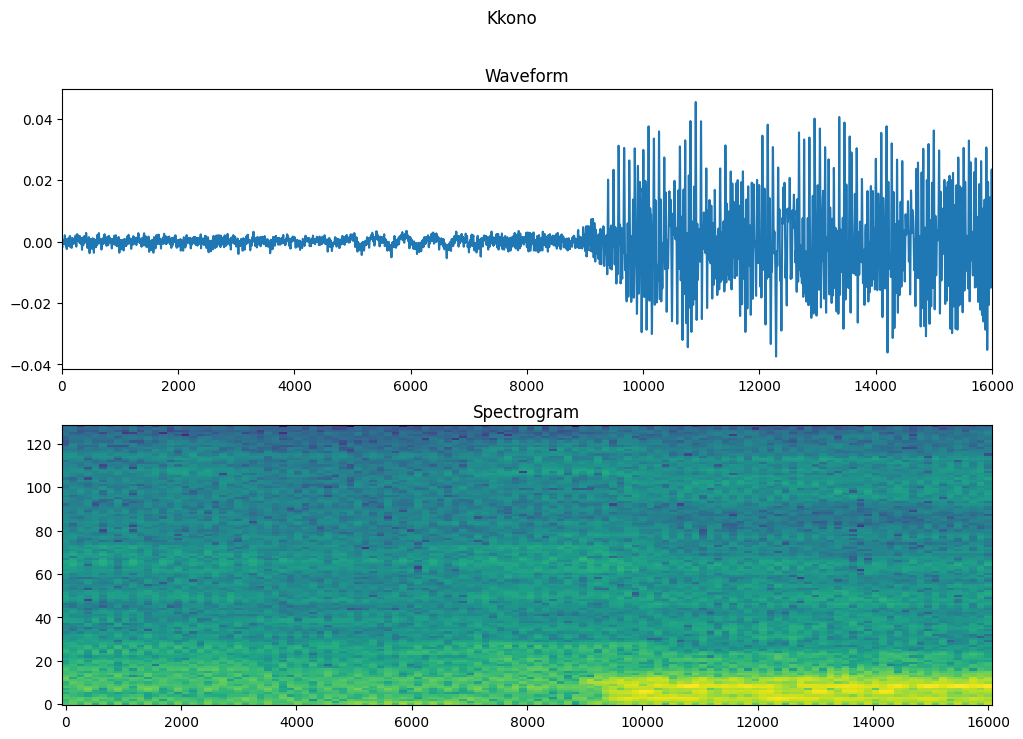

In [110]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

## Create spectrogram datasets from the audio datasets:

In [111]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [112]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Examine the spectrograms for different examples of the dataset:

In [113]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

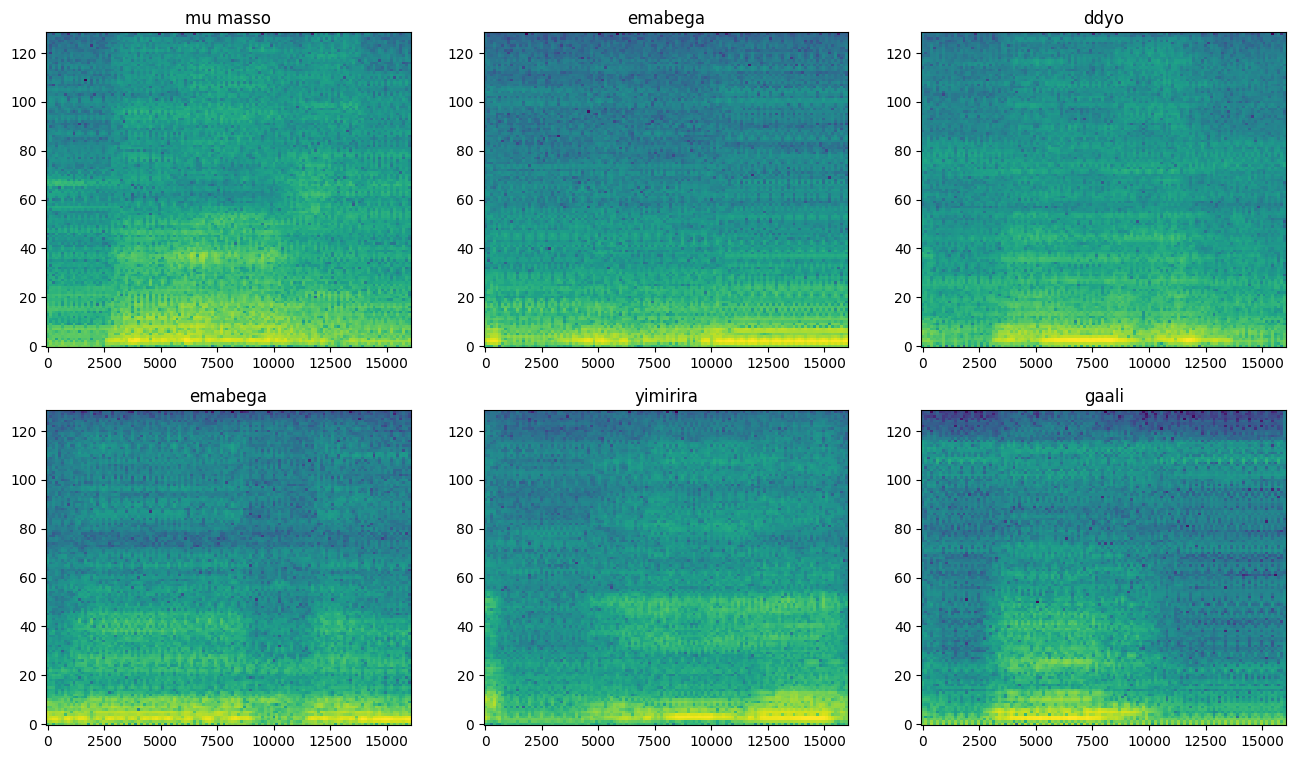

In [114]:
rows = 2
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

### `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [115]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

## Model 1

In [116]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)
norm_layer = layers.Normalization()
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_2 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_1 (Normaliza  (None, 32, 32, 1)         3         
 tion)                                                           
                                                                 
 conv2d_7 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)       

### Keras model with the Adam optimizer and the cross-entropy loss:

In [117]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

### Train the model

In [119]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
40/40 [==============================] - 4s 92ms/step - loss: 0.1926 - accuracy: 0.9409 - val_loss: 0.2611 - val_accuracy: 0.9160
Epoch 2/10
40/40 [==============================] - 4s 97ms/step - loss: 0.1846 - accuracy: 0.9361 - val_loss: 0.2614 - val_accuracy: 0.9258
Epoch 3/10
40/40 [==============================] - 4s 102ms/step - loss: 0.1793 - accuracy: 0.9385 - val_loss: 0.2590 - val_accuracy: 0.9258
Epoch 4/10
40/40 [==============================] - 4s 98ms/step - loss: 0.1598 - accuracy: 0.9484 - val_loss: 0.2521 - val_accuracy: 0.9336
Epoch 5/10
40/40 [==============================] - 4s 97ms/step - loss: 0.1659 - accuracy: 0.9464 - val_loss: 0.2676 - val_accuracy: 0.9258
Epoch 6/10
40/40 [==============================] - 4s 101ms/step - loss: 0.1315 - accuracy: 0.9552 - val_loss: 0.2688 - val_accuracy: 0.9336
Epoch 6: early stopping


### Plot the training and validation loss curves to check how your model has improved during training:

Text(0, 0.5, 'Accuracy [%]')

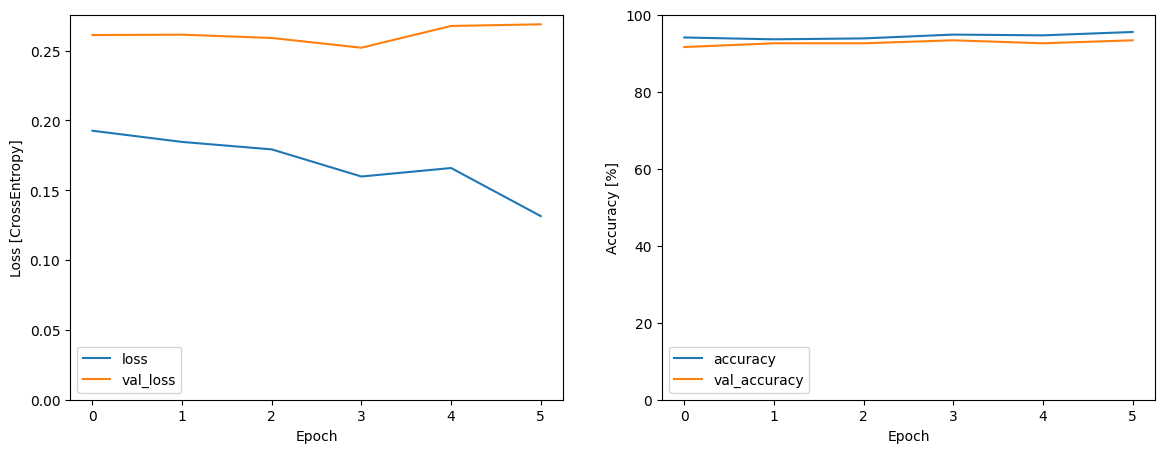

In [120]:
metrics = history.history
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Evaluate the model performance

Run the model on the test set and check the model's performance:

In [121]:
model.evaluate(test_spectrogram_ds, return_dict=True)

9/9 [==============================] - 1s 40ms/step - loss: 0.3087 - accuracy: 0.9049


{'loss': 0.3086625337600708, 'accuracy': 0.9049295783042908}

### Display a confusion matrix

In [122]:
y_pred = model.predict(test_spectrogram_ds)

9/9 [==============================] - 0s 22ms/step


In [123]:
y_pred = tf.argmax(y_pred, axis=1)

In [124]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

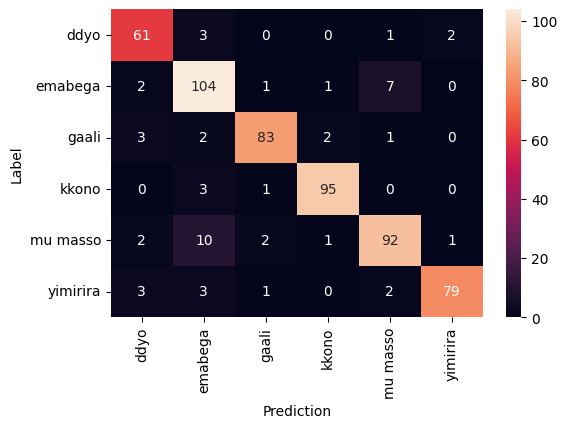

In [125]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

### Export the model with preprocessing

In [126]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch.
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it.
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]

    x = get_spectrogram(x)
    result = self.model(x, training=False)

    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

## Model 2

In [127]:
model2 = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])


In [128]:
model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_3 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_1 (Normaliza  (None, 32, 32, 1)         3         
 tion)                                                           
                                                                 
 conv2d_9 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 batch_normalization_2 (Bat  (None, 30, 30, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                      

In [129]:
model2.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

timizer=tf.keras.optimizers.Adam(),
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),


In [130]:
EPOCHS = 10
history = model2.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
40/40 [==============================] - 3s 44ms/step - loss: 1.3914 - accuracy: 0.5813 - val_loss: 1.6626 - val_accuracy: 0.3496
Epoch 2/10
40/40 [==============================] - 2s 38ms/step - loss: 0.6188 - accuracy: 0.7881 - val_loss: 1.6246 - val_accuracy: 0.3105
Epoch 3/10
40/40 [==============================] - 2s 39ms/step - loss: 0.4703 - accuracy: 0.8405 - val_loss: 1.7445 - val_accuracy: 0.3633
Epoch 4/10
40/40 [==============================] - 2s 39ms/step - loss: 0.3902 - accuracy: 0.8698 - val_loss: 1.9912 - val_accuracy: 0.3789
Epoch 4: early stopping


Text(0, 0.5, 'Accuracy [%]')

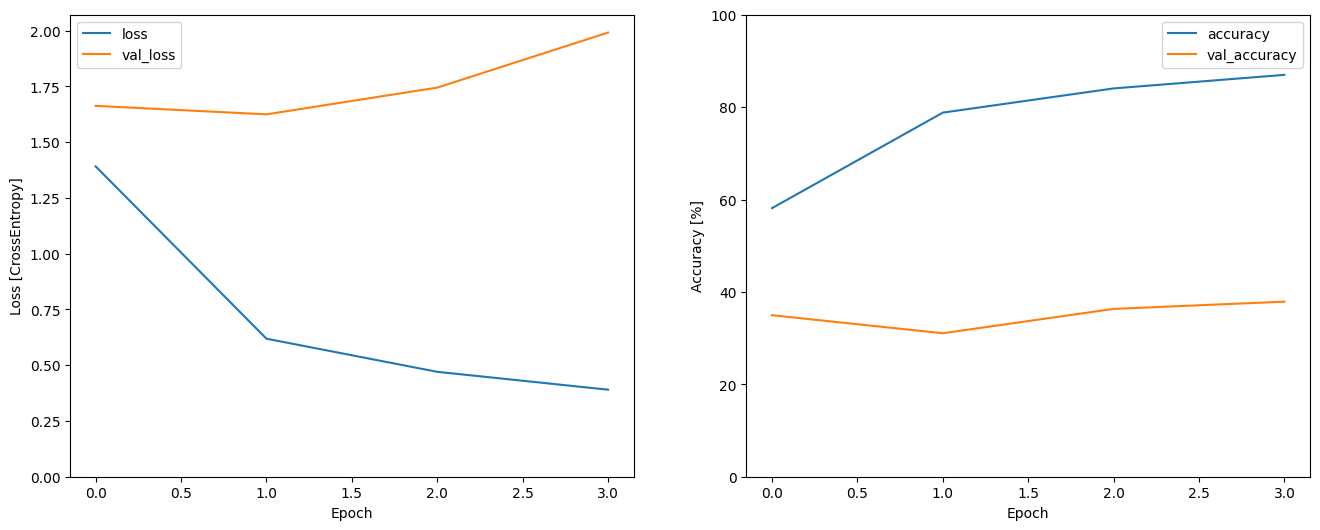

In [131]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Evaluate the model

In [74]:
model2.evaluate(test_spectrogram_ds, return_dict=True)

6/6 [==============================] - 0s 8ms/step - loss: 2.0983 - accuracy: 0.3568


{'loss': 2.0982983112335205, 'accuracy': 0.3567708432674408}

In [75]:
y_pred = model2.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)

6/6 [==============================] - 0s 8ms/step


In [76]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

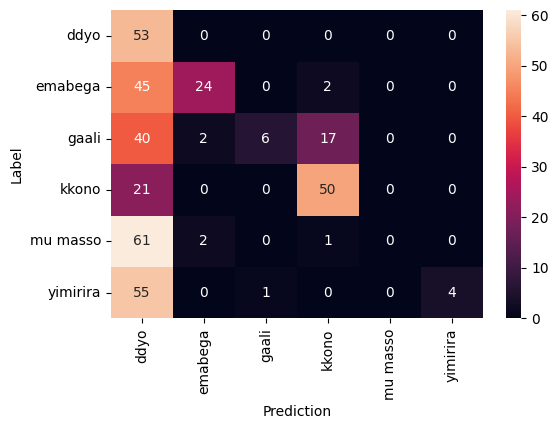

In [77]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Model 3

In [78]:
model3 = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(32, 3, activation='relu', dilation_rate=(2, 2)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu', dilation_rate=(2, 2)),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu', dilation_rate=(2, 2)),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])


In [79]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 120, 125, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 60, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 56, 58, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 28, 29, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 24, 25, 128)       73856     
                                                                 
 global_average_pooling2d (  (None, 128)              

In [80]:
model3.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [81]:
EPOCHS = 10
history = model3.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
45/45 [==============================] - 29s 628ms/step - loss: 1.7431 - accuracy: 0.2149 - val_loss: 1.6141 - val_accuracy: 0.3274
Epoch 2/10
45/45 [==============================] - 30s 661ms/step - loss: 1.3581 - accuracy: 0.4750 - val_loss: 1.2013 - val_accuracy: 0.5446
Epoch 3/10
45/45 [==============================] - 30s 662ms/step - loss: 1.0733 - accuracy: 0.6007 - val_loss: 1.0580 - val_accuracy: 0.5923
Epoch 4/10
45/45 [==============================] - 32s 705ms/step - loss: 0.9482 - accuracy: 0.6510 - val_loss: 0.9867 - val_accuracy: 0.6190
Epoch 5/10
45/45 [==============================] - 32s 722ms/step - loss: 0.8923 - accuracy: 0.6812 - val_loss: 0.9554 - val_accuracy: 0.6101
Epoch 6/10
45/45 [==============================] - 32s 716ms/step - loss: 0.8445 - accuracy: 0.6934 - val_loss: 0.9236 - val_accuracy: 0.6429
Epoch 7/10
45/45 [==============================] - 31s 699ms/step - loss: 0.7996 - accuracy: 0.7160 - val_loss: 0.9121 - val_accuracy: 0.6845

Text(0, 0.5, 'Accuracy [%]')

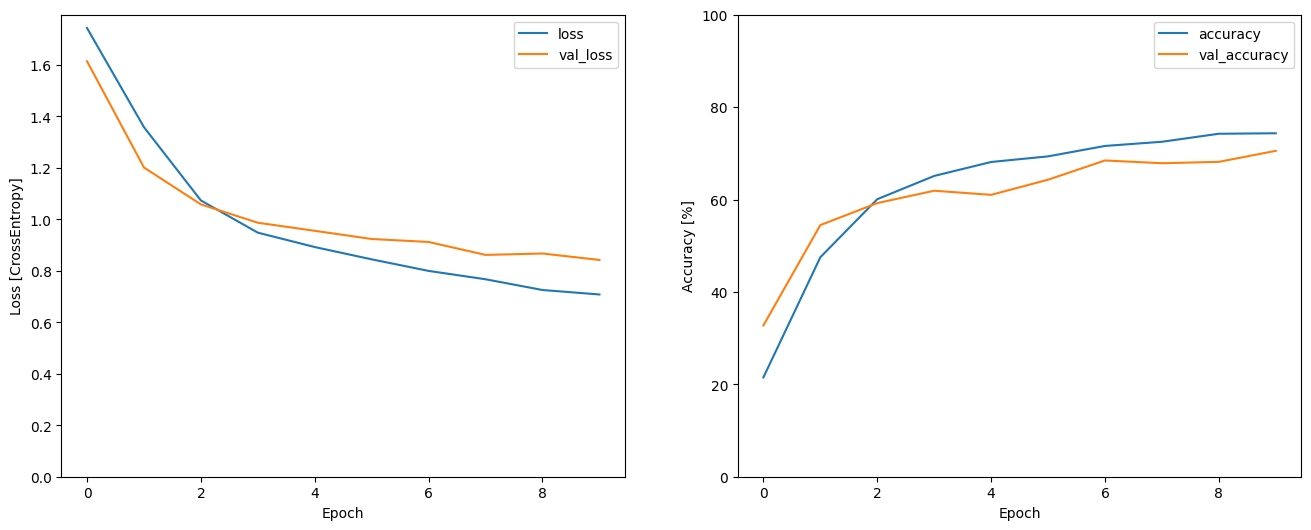

In [82]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Evaluate the model

In [83]:
model3.evaluate(test_spectrogram_ds, return_dict=True)

6/6 [==============================] - 1s 246ms/step - loss: 0.6487 - accuracy: 0.7526


{'loss': 0.6486705541610718, 'accuracy': 0.7526041865348816}

In [84]:
y_pred = model3.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)

6/6 [==============================] - 2s 251ms/step


In [85]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

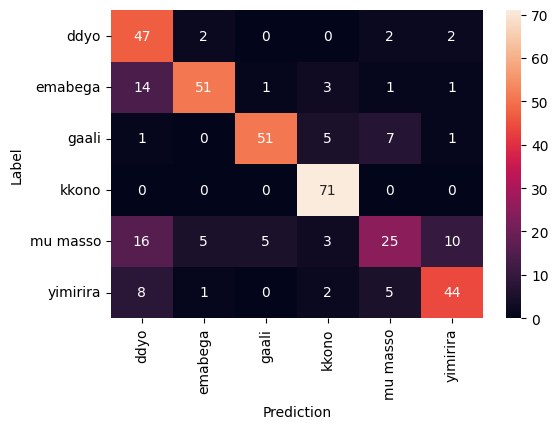

In [86]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Model 4

In [87]:

train_spectrogram_ds = train_spectrogram_ds.map(lambda x, y: (tf.image.grayscale_to_rgb(x), y))
val_spectrogram_ds = val_spectrogram_ds.map(lambda x, y: (tf.image.grayscale_to_rgb(x), y))

In [88]:
input_shape = (124, 129, 3) 
base_model = tf.keras.applications.MobileNetV2(
    input_shape=input_shape, include_top=False, weights='imagenet')
base_model.trainable = False

model4 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])


In [89]:
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 4, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 128)               163968    
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 6)                 774       
                                                                 
Total params: 2422726 (9.24 MB)
Trainable params: 1647

In [90]:
model4.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [91]:
EPOCHS = 10
history = model4.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
45/45 [==============================] - 20s 349ms/step - loss: 1.3112 - accuracy: 0.5132 - val_loss: 0.9246 - val_accuracy: 0.6518
Epoch 2/10
45/45 [==============================] - 14s 319ms/step - loss: 0.8616 - accuracy: 0.6892 - val_loss: 0.7472 - val_accuracy: 0.7470
Epoch 3/10
45/45 [==============================] - 14s 323ms/step - loss: 0.7358 - accuracy: 0.7427 - val_loss: 0.6727 - val_accuracy: 0.7738
Epoch 4/10
45/45 [==============================] - 15s 325ms/step - loss: 0.6811 - accuracy: 0.7531 - val_loss: 0.6319 - val_accuracy: 0.7679
Epoch 5/10
45/45 [==============================] - 15s 325ms/step - loss: 0.6111 - accuracy: 0.7767 - val_loss: 0.6026 - val_accuracy: 0.7798
Epoch 6/10
45/45 [==============================] - 15s 327ms/step - loss: 0.5833 - accuracy: 0.7899 - val_loss: 0.5624 - val_accuracy: 0.7917
Epoch 7/10
45/45 [==============================] - 15s 327ms/step - loss: 0.5271 - accuracy: 0.8149 - val_loss: 0.5580 - val_accuracy: 0.8065

Text(0, 0.5, 'Accuracy [%]')

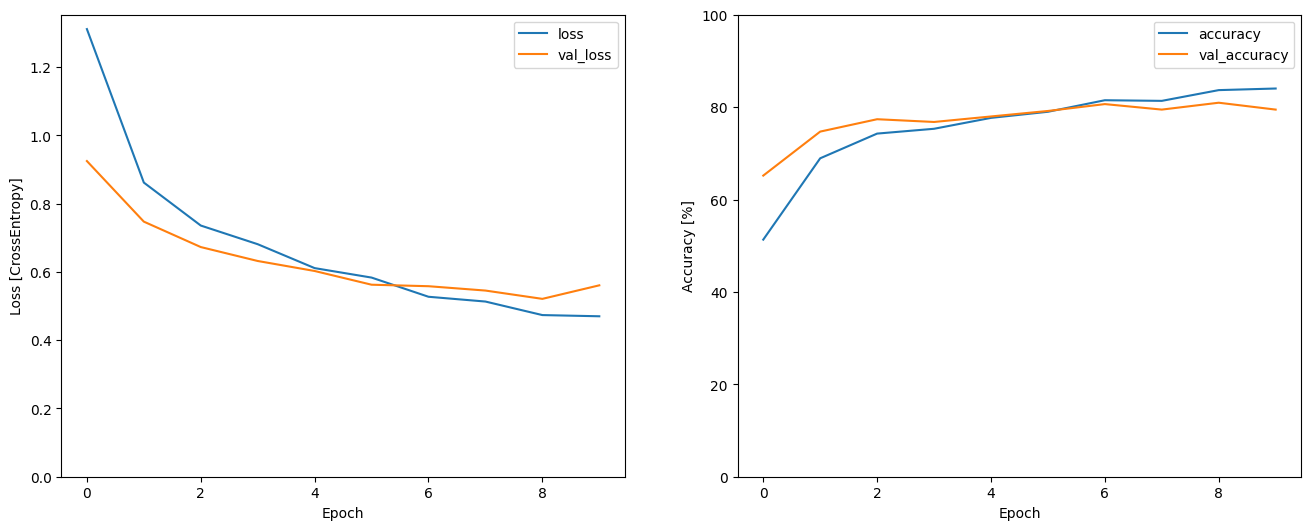

In [92]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Evaluate the model

In [93]:
model4.evaluate(val_spectrogram_ds, return_dict=True)


6/6 [==============================] - 1s 235ms/step - loss: 0.5606 - accuracy: 0.7946


{'loss': 0.5606337785720825, 'accuracy': 0.7946428656578064}

In [94]:
y_pred = model4.predict(val_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)

6/6 [==============================] - 2s 221ms/step


In [95]:
y_true = tf.concat(list(val_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

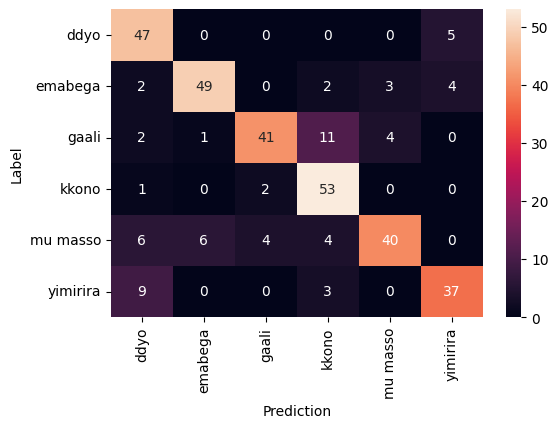

In [96]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

# Exporting a model

## Export the model with preprocessing

In [97]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch.
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it.
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]

    x = get_spectrogram(x)
    result = self.model(x, training=False)

    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

In [98]:
export = ExportModel(model)
export(tf.constant(str('own/ddyo/audio #2001.wav')))

{'predictions': <tf.Tensor: shape=(1, 6), dtype=float32, numpy=
 array([[-118.83273  ,    3.0168517,  349.7217   ,  -80.65847  ,
           25.569756 , -174.36504  ]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([2])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'gaali'], dtype=object)>}

Save and reload the model, the reloaded model gives identical output:

In [99]:
tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")
imported(waveform[tf.newaxis, :])

INFO:tensorflow:Assets written to: saved/assets


INFO:tensorflow:Assets written to: saved/assets


{'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([3])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'kkono'], dtype=object)>,
 'predictions': <tf.Tensor: shape=(1, 6), dtype=float32, numpy=
 array([[-2.153601 , -0.9881042,  0.6586656, 13.002021 , -4.809059 ,
         -3.7743418]], dtype=float32)>}